In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel, WeightedDegree_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Plot for regression

In [2]:
Path = '../../data/firstRound_Microplate_normTrue_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,1.616261,1.814182,1.760954,2.186207,2.028863,1.831982,1.881293,0.225819
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,1.166174,1.337018,1.417248,1.493800,1.713526,1.644568,1.425553,0.201725
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.604551,0.751384,0.851987,0.514929,0.577299,0.795227,0.660030,0.137994
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,1.221264,1.466278,1.270212,1.341040,1.395030,1.175433,1.338765,0.097386
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,1.160566,1.579025,1.171829,1.590670,1.411255,1.756862,1.382669,0.210012
5,5,RBS_1by1_5,bps_noncore,TGTAAGAAGGAGATATACAT,AGGAGA,0.288674,0.268222,0.486638,0.254308,0.342162,0.501763,0.328001,0.094759
6,6,RBS_1by1_6,bps_noncore,TATAAGAAGGAGATATACAT,AGGAGA,1.003687,1.116599,0.851400,0.866754,1.075506,1.462978,0.982789,0.120068
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,1.138820,1.342549,NaN,1.626269,1.423415,1.806580,1.382763,0.201720
8,9,RBS_1by1_9,bps_noncore,TTAAAGAAGGAGATATACAT,AGGAGA,0.508605,0.646307,1.153507,0.488646,0.406578,0.583543,0.640728,0.299326
9,10,RBS_1by1_10,bps_noncore,TTTCAGAAGGAGATATACAT,AGGAGA,1.119059,0.876151,0.624684,1.321343,1.066000,1.621663,1.001447,0.263620


X train shape:  (704, 20)
X test shape:  (35, 20)
create kernel instance
finish creating kernel instance
After centering
(704, 704)
eigh:
(array([9.99999999e-05, 9.99999999e-05, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.

After centering
(704, 704)
eigh:
(array([9.99999999e-05, 9.99999999e-05, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00

After centering
(704, 704)
eigh:
(array([9.99999999e-05, 9.99999999e-05, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00

After centering
(704, 704)
eigh:
(array([9.99999999e-05, 9.99999999e-05, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00

After centering
(35, 704)
After centering
(35, 35)
eigh:
(array([-1.50274804,  0.05034144,  0.08066776,  0.12210764,  0.12792095,
        0.14685939,  0.18686712,  0.19239172,  0.22686856,  0.24025215,
        0.26236817,  0.29214837,  0.31275347,  0.35417793,  0.36576979,
        0.39500123,  0.42270525,  0.4579349 ,  0.46223881,  0.48823061,
        0.52028883,  0.55538216,  0.5774648 ,  0.61363198,  0.63929064,
        0.75823034,  0.83629506,  0.86909387,  0.95529607,  1.05288791,
        1.26039909,  1.64505588,  1.78557794,  5.0635396 , 14.18620863]), array([[ 0.05415078, -0.03481262, -0.0770305 , ...,  0.14888888,
         0.17979643, -0.13686857],
       [ 0.04595412,  0.00723373, -0.00926417, ...,  0.03941563,
         0.11746525, -0.16135121],
       [-0.08121219, -0.0061404 ,  0.0140291 , ..., -0.06510174,
         0.11625593, -0.19596328],
       ...,
       [ 0.04782587,  0.09074772,  0.26174468, ..., -0.13392203,
         0.20340799, -0.14039399],
       [-0.0697319 ,  0.

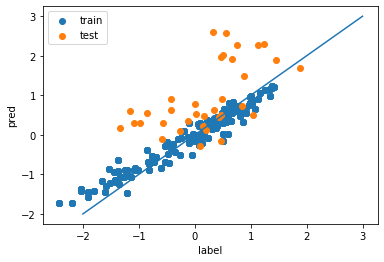

In [3]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = mean_squared_error

gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric, normalise_kernel = True,
                   l_list = [6], s = 2, alpha = 0.5, use_samples_for_train=True)
gpr_train_samples.regression()
gpr_train_samples.scatter_plot()

In [4]:
gpr_train_samples.test_df

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD,pred mean,pred std
108,109,RBS_BA_19,bandit,TTTAAGATAAGATTATACAT,TAAGAT,-0.440723,-1.407786,-1.373892,-2.035393,-0.553289,-0.662509,-1.162217,0.663116,0.594749,0.844520
159,161,RBS_RP_41,prob random,TTTAAGATACTGATATACAT,TACTGA,0.381380,0.686505,0.504649,0.206063,0.418553,0.138494,0.439430,0.175760,0.446940,0.871215
93,94,RBS_BA_04,bandit,TTTAAGAGCCGGATATACAT,GCCGGA,0.575108,0.631228,0.484304,0.445865,0.200938,-0.034606,0.467489,0.165976,0.503969,0.787914
151,153,RBS_RP_33,prob random,TTTAAGACCGGGATATACAT,CCGGGA,-0.911192,-0.659232,-0.322793,-0.385093,-1.967401,-1.095854,-0.849142,0.667608,0.556859,0.808029
57,58,RBS_1by1_58,bps_noncore,TTTAAGAAGGAGATATACAC,AGGAGA,0.855386,0.772457,0.714765,1.130928,0.958318,1.408394,0.886371,0.164598,1.485763,0.620724
26,27,RBS_1by1_27,bps_core,TTTAAGAATGAGATATACAT,ATGAGA,-0.579086,-0.474276,0.022355,-0.561411,-0.547485,-1.840800,-0.427981,0.254884,0.627390,0.741186
112,114,RBS_BA_24,bandit,TTTAAGAGGGGGATATACAT,GGGGGA,0.405390,0.830303,1.117253,1.315338,1.568453,1.176796,1.047348,0.449298,0.499858,0.738782
78,79,RBS_RU_18,uni random,TTTAAGAACCGTGTATACAT,ACCGTG,-0.233672,-0.797632,-0.396004,-0.789864,-0.721970,-0.931346,-0.587828,0.257417,-0.094893,0.784433
25,26,RBS_1by1_26,bps_core,TTTAAGAAAGAGATATACAT,AAGAGA,0.011928,-0.155133,0.990007,-0.429727,-0.371476,-0.081111,0.009120,0.575883,0.769086,0.711474
88,89,RBS_RU_28,uni random,TTTAAGACGAGACTATACAT,CGAGAC,-0.030545,-0.286107,0.099052,-0.459366,0.103592,-0.110506,-0.114675,0.249298,0.343717,0.777892


In [5]:
kernel_matrix_samples = WD_Shift_Kernel(l_list = [6], features = gpr_train_samples.features, s = 1, normalise_kernel_flag=True).__call__(np.asarray(gpr_train_samples.train_df['RBS']), np.asarray(gpr_train_samples.train_df['RBS']))
#np.linalg.eig(kernel_matrix)

After centering
(704, 704)
eigh:
(array([9.99999999e-05, 9.99999999e-05, 9.99999999e-05, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00

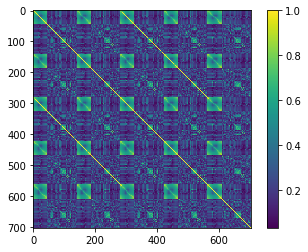

In [6]:
plt.imshow(kernel_matrix_samples)
plt.colorbar()

In [7]:
np.linalg.eigh(kernel_matrix_samples)

(array([9.99999999e-05, 9.99999999e-05, 9.99999999e-05, 1.00000000e-04,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
        1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.000000

## Train sequences

X train shape:  (141, 20)
X test shape:  (35, 20)
create kernel instance
finish creating kernel instance
After centering
(141, 141)
eigh:
(array([1.73978226e-02, 1.82319935e-02, 2.87908099e-02, 4.01006318e-02,
       4.34556566e-02, 4.55403217e-02, 4.94426533e-02, 6.00843159e-02,
       6.32937038e-02, 6.72327307e-02, 6.94637481e-02, 7.03188008e-02,
       7.34165293e-02, 7.74112852e-02, 7.96063836e-02, 8.26539488e-02,
       8.51234640e-02, 8.96705300e-02, 8.97376399e-02, 9.17212405e-02,
       9.41801035e-02, 9.50612751e-02, 9.64130183e-02, 1.00065445e-01,
       1.01172058e-01, 1.02138029e-01, 1.06414700e-01, 1.06791959e-01,
       1.08277963e-01, 1.11006904e-01, 1.13144517e-01, 1.20132382e-01,
       1.24412163e-01, 1.28096166e-01, 1.28645303e-01, 1.31125292e-01,
       1.31327645e-01, 1.33791415e-01, 1.34676431e-01, 1.37567963e-01,
       1.42582779e-01, 1.46706901e-01, 1.49001713e-01, 1.50690394e-01,
       1.54172299e-01, 1.56753343e-01, 1.62346683e-01, 1.64395342e-01,
       1.

After centering
(141, 141)
eigh:
(array([1.73978226e-02, 1.82319935e-02, 2.87908099e-02, 4.01006318e-02,
       4.34556566e-02, 4.55403217e-02, 4.94426533e-02, 6.00843159e-02,
       6.32937038e-02, 6.72327307e-02, 6.94637481e-02, 7.03188008e-02,
       7.34165293e-02, 7.74112852e-02, 7.96063836e-02, 8.26539488e-02,
       8.51234640e-02, 8.96705300e-02, 8.97376399e-02, 9.17212405e-02,
       9.41801035e-02, 9.50612751e-02, 9.64130183e-02, 1.00065445e-01,
       1.01172058e-01, 1.02138029e-01, 1.06414700e-01, 1.06791959e-01,
       1.08277963e-01, 1.11006904e-01, 1.13144517e-01, 1.20132382e-01,
       1.24412163e-01, 1.28096166e-01, 1.28645303e-01, 1.31125292e-01,
       1.31327645e-01, 1.33791415e-01, 1.34676431e-01, 1.37567963e-01,
       1.42582779e-01, 1.46706901e-01, 1.49001713e-01, 1.50690394e-01,
       1.54172299e-01, 1.56753343e-01, 1.62346683e-01, 1.64395342e-01,
       1.66577312e-01, 1.69240336e-01, 1.71290735e-01, 1.73154588e-01,
       1.77162908e-01, 1.78799719e-01, 1.81

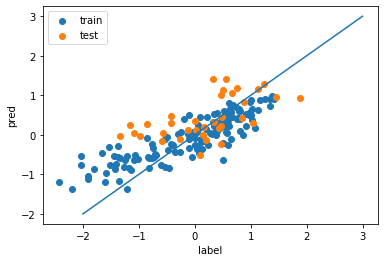

In [8]:
gpr_train_seqs = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric, normalise_kernel = True,
                   l_list = [6], s = 2, alpha = 0.5, use_samples_for_train=False)
gpr_train_seqs.regression()
gpr_train_seqs.scatter_plot()

## Repeated KFold

In [9]:
import pickle

with open('kflod_results/repeated_kfold_wd_shift_logTrue_evaSeq.pickle', 'rb') as handle:
    result_pkl = pickle.load(handle)

In [10]:
import xarray
result_test_s0_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 0)].mean(axis = -1).mean(axis = -1)
result_test_s1_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 1)].mean(axis = -1).mean(axis = -1)
result_test_s2_aveSplit_aveRepeat = result_pkl[1].loc[dict(s = 2)].mean(axis = -1).mean(axis = -1)

In [11]:
result_test_s0_aveSplit_aveRepeat

<xarray.DataArray (alpha: 21, l: 4)>
array([[1.26233808, 1.21934278, 1.22246368, 1.10961882],
       [0.87459999, 0.87055171, 0.89713976, 0.85547907],
       [0.80702986, 0.83542606, 0.7892894 , 0.79315209],
       [0.79325253, 0.78738795, 0.77396435, 0.75315738],
       [0.7807854 , 0.79277263, 0.74850416, 0.74925239],
       [0.78557403, 0.76527113, 0.75953693, 0.74250648],
       [0.77974293, 0.7499474 , 0.75541773, 0.73589765],
       [0.76827697, 0.76355223, 0.75677268, 0.76297781],
       [0.77190605, 0.755155  , 0.74417191, 0.73820289],
       [0.76817021, 0.7678082 , 0.74778035, 0.7373879 ],
       [0.76324691, 0.76190945, 0.74107088, 0.73617823],
       [0.77021022, 0.75805215, 0.75020015, 0.75312134],
       [0.77042698, 0.76062137, 0.75078407, 0.74486233],
       [0.78048303, 0.75572055, 0.74794436, 0.74768476],
       [0.7685245 , 0.75632756, 0.74770342, 0.74510788],
       [0.76589546, 0.76415929, 0.74522604, 0.74827753],
       [0.77253683, 0.76538293, 0.74385624, 0.74639469],
       [0.77443947, 0.76357087, 0.7573345 , 0.74543478],
       [0.76844234, 0.7607419 , 0.74840374, 0.74997674],
       [0.77345261, 0.76044826, 0.75561943, 0.75037812],
       [0.76387207, 0.76333613, 0.75403397, 0.75108625]])
Coordinates:
    train_test  <U5 'Test'
  * alpha       (alpha) int64 1 10 20 30 40 50 60 ... 150 160 170 180 190 200
  * l           (l) <U3 '[3]' '[4]' '[5]' '[6]'
    s           int64 0

In [12]:
result_test_s0_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]
result_test_s1_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]
result_test_s2_aveSplit_aveRepeat.coords['l'] = [3,4,5,6]

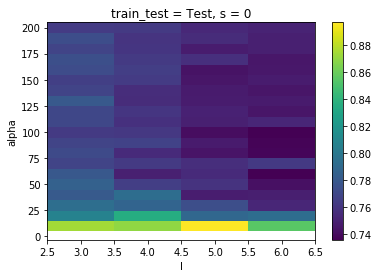

In [13]:
result_test_s0_aveSplit_aveRepeat.where(result_test_s0_aveSplit_aveRepeat < 1).plot()

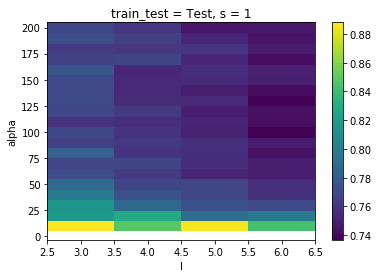

In [14]:
result_test_s1_aveSplit_aveRepeat.where(result_test_s1_aveSplit_aveRepeat < 1).plot()

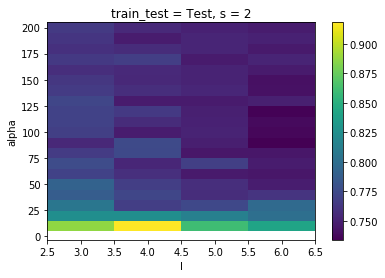

In [15]:
result_test_s2_aveSplit_aveRepeat.where(result_test_s2_aveSplit_aveRepeat < 1).plot()

In [16]:
# average mean square error for testing 

result_pkl[1].loc[dict(s = 1)].loc[dict(l = '[6]')].mean(axis = -1).mean(axis = -1)

<xarray.DataArray (alpha: 21)>
array([1.1512797 , 0.84359855, 0.79909973, 0.77068351, 0.75755586,
       0.75657694, 0.74872428, 0.74963607, 0.74386427, 0.74837986,
       0.73680298, 0.74181425, 0.74306736, 0.73768472, 0.74125225,
       0.75029304, 0.75087085, 0.74175137, 0.74907985, 0.74476065,
       0.74683378])
Coordinates:
    train_test  <U5 'Test'
  * alpha       (alpha) int64 1 10 20 30 40 50 60 ... 150 160 170 180 190 200
    l           <U3 '[6]'
    s           int64 1

In [17]:
# std of mean square error for testing

result_pkl[1].loc[dict(s = 1)].loc[dict(l = '[6]')].mean(axis = -1).std(axis = -1)

<xarray.DataArray (alpha: 21)>
array([0.09969509, 0.02697518, 0.04492847, 0.02948356, 0.02706565,
       0.0233904 , 0.02620881, 0.02209315, 0.02025293, 0.01341702,
       0.01194087, 0.02283254, 0.01004528, 0.01353901, 0.01234023,
       0.01097683, 0.01417145, 0.01417162, 0.02050755, 0.00907089,
       0.00887418])
Coordinates:
    train_test  <U5 'Test'
  * alpha       (alpha) int64 1 10 20 30 40 50 60 ... 150 160 170 180 190 200
    l           <U3 '[6]'
    s           int64 1